# import

In [1]:
## on nuke, we use env `anaconda3` due to `base` being outdated

import os
from tqdm import tqdm
from IPython.display import clear_output

import numpy as np
from numpy import dot
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

# df_tidy load

In [2]:
dir_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
fig_dir = r'C:\Users\lan\Documents\repos\inter\results\decorrelation vs adp\ref=self before adp'.replace('\\', os.sep)
dir_file = os.path.join(dir_inter, 'adp_dataset_master.xlsx')
data_info = pd.read_excel(dir_file)
data_info.head()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LM')
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # ensure segmentation
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_LM = meta.copy()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'V1') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # there are 2 data in V1 that haven't been segmented due to cellpose failing with low quality tiff
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_V1 = meta.copy()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LI') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & (data_info.manual_seg != 'TODO') # 2 LI data still need manual segm
                 & (data_info.note.str.contains('bad') != True) # exclude bad data
                 ]
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_LI = meta.copy()

meta = pd.concat([meta_V1, meta_LM, meta_LI], axis=0).reset_index(drop=True)
# meta

area
LM    22
Name: count, dtype: int64 22
area
V1    6
Name: count, dtype: int64 6
area
LI    18
Name: count, dtype: int64 18


In [3]:
nset = len(meta)
df_tidy = pd.DataFrame()

for iset in tqdm(range(nset)):
    # print(f'iset={iset}, nset={nset}')

    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    # sess = '00' + meta.loc[iset, 'num'].astype(str)
    sess = meta.loc[iset, 'num']
    # print(imouse, date, area, sess)
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    csv_filename = 'df_tidy_continuous_vis_pval.csv'
    try:
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))
    except:
        dir_identifier = dir_identifier + '_cellpose'
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))

    df_tidy_now['mouse'] = mouse
    df_tidy_now['date'] = date
    df_tidy_now['sess'] = sess
    df_tidy_now['cell_id'] = (df_tidy_now.date.astype(str) + '_' 
                               + df_tidy_now.sess.astype(str) + '_' 
                               + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates, sessions
    df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    # break
    
clear_output()

# print(df_tidy.mouse.unique(), 
#       df_tidy.date.unique(), 
#       df_tidy.sess.unique(), 
#       df_tidy.area.unique(), 
#       df_tidy.isi.unique(), 
#       df_tidy.stim1_contrast.unique(), 
#       df_tidy.stim2_id.unique(), 
#       df_tidy.resp_id.unique())
# df_tidy.sample(5, random_state=0)

# decorr data prep

In [4]:
pd.options.mode.chained_assignment = None  # default='warn' # suppress SettingWithCopyWarning

def get_df_decorr(df_tidy, current_area):
  df_decorr = df_tidy[['dfof', 
                      'cell_id', 'resp_id', 'isi', 'stim2_id', 
                      'filter_cell_vis', 'filter_cell_stim', 'filter_cell_well_fit', 
                      'area', 'mouse', 'date', 'sess'
                      ]]

  df_decorr['stim2_dist'] = df_decorr.stim2_id.apply(lambda x: 22.5*(8-x) if x > 4 else 22.5*x) 
                            # stim2 distance from 0 deg, hard coded for 8 ori. TODO: modify if needed
  df_decorr['date_sess'] = df_decorr.date + '_' + df_decorr.sess

  df_decorr = df_decorr[(df_decorr.isi != 750)
                        & (df_decorr.resp_id == 'R2') # repre of 8ori, with or without 0 deg adapter
                        & (df_decorr.area == current_area)
                        & (df_decorr.filter_cell_vis == True)
                        # & (df_decorr.filter_cell_stim == True)
                        # & (df_decorr.filter_cell_well_fit == True) # well fit doesn't help decorr
                      ]
  return df_decorr

# decorr from self
before vs after adp

In [79]:
df_decorr = get_df_decorr(df_tidy, current_area='V1')

In [53]:
cos_sim_sets = []
for iset in tqdm(df_decorr.date_sess.unique()):
    
    df_pop_vec = (df_decorr[df_decorr.date_sess == iset]
                  .groupby(['isi', 'stim2_dist', 'cell_id'])
                  .dfof.mean().reset_index()
                  .pivot_table(index=['isi', 'stim2_dist'], 
                               columns='cell_id', 
                               values='dfof') # for each isi and stim2_dist, get a pop vector of size [ncell, 1]
                )
    nori = df_decorr.stim2_dist.nunique()
    
    cos_sim_iset = []
    for iori in range(nori):
        pop_vec_ref = df_pop_vec.iloc[nori + iori, :].values # ref is the same ori, but before adp (isi=6000)
        pop_vec_ori = df_pop_vec.iloc[iori, :].values # pop vec after adp (isi=250)
        cos_sim = dot(pop_vec_ref, pop_vec_ori) / (norm(pop_vec_ref) * norm(pop_vec_ori)) # cosine similarity
        cos_sim_iset.append(cos_sim)
    cos_sim_sets.append(cos_sim_iset)
    
len(cos_sim_sets), len(cos_sim_sets[0]) # n of recording, n of self-decorrelation pairs (nori)

100%|██████████| 6/6 [00:00<00:00, 61.17it/s]


(6, 5)

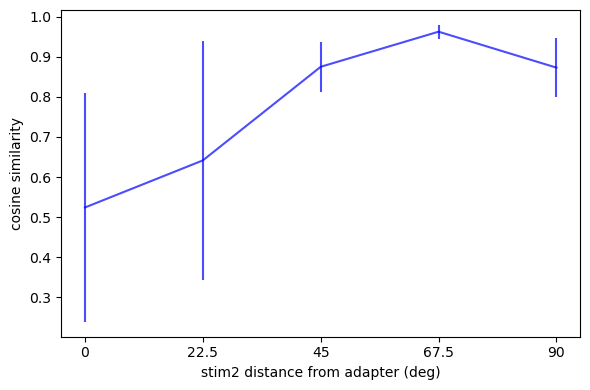

In [54]:
cos_sim_sets = np.array(cos_sim_sets)
cos_sim_sets_avg = np.nanmean(cos_sim_sets, axis=0) # across recordings
cos_sim_sets_sem = np.nanstd(cos_sim_sets, axis=0) / np.sqrt(cos_sim_sets.shape[0])

fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharex=True)
ax.errorbar(x=np.arange(len(cos_sim_sets_avg)),
               y=cos_sim_sets_avg,
               yerr=cos_sim_sets_sem,
               color='blue', # label='isi 250', 
               alpha=0.7)

# ax.legend(frameon=False, loc='lower center')
ax.set_xlabel('stim2 distance from adapter (deg)');
ax.set_ylabel('cosine similarity')
ax.set_xticks(range(nori), ['0', '22.5', '45', '67.5', '90'])

fig.tight_layout();
fig_name = 'decorr_from_self_after_adp_well_fit_' + current_area + '.pdf'
# plt.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

# decorr from ref ori

if resample cells without affecting trials: 
1. groupby cell_id, then sample n cells. set cell_id as index, use df.reindex(cell_id) to get the resampled df
2. set cell_id as index in df_decorr, df_decorr[df_decorr.cell_id.isin(subsample_cell)] -> df.reindex
3. df_pop_vec. ... .groupby, reset_index, sample n cells, pivot_table

In [5]:
(df_tidy[(df_tidy.filter_cell_vis == True)
        # & (df_tidy.filter_cell_stim == True)
        # & (df_tidy.filter_cell_well_fit == True)
         ]
        .groupby('area')
        .cell_id.nunique())

area
LI    222
LM    983
V1    449
Name: cell_id, dtype: int64

## decorr vs stim2_ori

In [125]:
current_area = 'LI'
df_decorr = get_df_decorr(df_tidy, current_area=current_area)

df_pop_vec = (df_decorr.groupby(['isi', 'stim2_id', 'cell_id'])
                .dfof.mean().reset_index()
                .pivot_table(index=['isi', 'stim2_id'], columns='cell_id', values='dfof')
                )

nori = df_decorr.stim2_id.nunique()
nisi_now = df_decorr.isi.nunique() # discarded isi 750

cos_sim_list = []
for iisi in range(nisi_now):
    
    if iisi == 0:
        iref = 4 # use 90 deg as ref
    elif iisi == 1:
        iref = nori+4 # -1 (0-based indexing) and +1 (go to next isi) cancel out
    pop_vec_ref = df_pop_vec.iloc[iref, :].values # reference pop vec: 0 deg target resp
    
    for iori in range(nori):
        irow = iisi * nori + iori
        # print(iisi, iori, irow)
        pop_vec_ori = df_pop_vec.iloc[irow, :].values
        cos_sim = dot(pop_vec_ref, pop_vec_ori) / (norm(pop_vec_ref) * norm(pop_vec_ori))
        cos_sim_list.append(cos_sim)

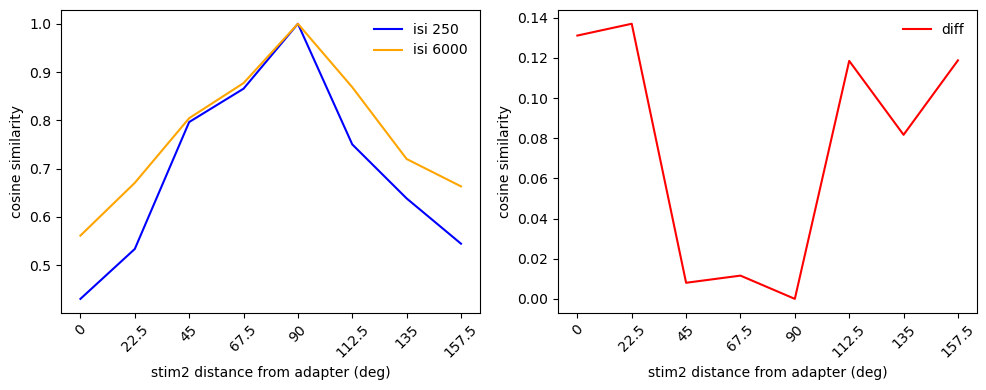

In [126]:
cos_sim_list = np.array(cos_sim_list)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
ax[0].plot(cos_sim_list[:nori], color='blue', label='isi 250')
ax[0].plot(cos_sim_list[nori:2*nori], color='orange', label='isi 6000')
ax[0].legend(frameon=False)

ax[1].plot(cos_sim_list[nori:2*nori] - cos_sim_list[:nori], color='red', label='diff')
ax[1].legend(frameon=False)

ax[0].set_xlabel('stim2 distance from adapter (deg)');
ax[0].set_ylabel('cosine similarity')
ax[0].set_xticks(range(nori), ['0', '22.5', '45', '67.5', '90', '112.5', '135', '157.5'], rotation=45)

ax[1].set_xlabel('stim2 distance from adapter (deg)');
ax[1].set_ylabel('cosine similarity')
ax[1].set_xticks(range(nori), ['0', '22.5', '45', '67.5', '90', '112.5', '135', '157.5'], rotation=45)

plt.tight_layout()
# fig_dir = r'C:\Users\lan\Documents\repos\inter\results\decorrelation vs adp\ref=90 deg'.replace('\\', os.sep)
# fig_name = 'decorr_vs_stim2_ori_' + current_area + '.pdf'
# plt.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

## decorr vs stim2_dist
distance from adapter (0 deg)

In [132]:
current_area = 'LI'
df_decorr = get_df_decorr(df_tidy, current_area=current_area)

df_pop_vec = (df_decorr.groupby(['isi', 'stim2_dist', 'cell_id'])
                .dfof.mean().reset_index()
                .pivot_table(index=['isi', 'stim2_dist'], columns='cell_id', values='dfof')
                )

nori = df_decorr.stim2_dist.nunique()
nisi_now = df_decorr.isi.nunique() # discarded isi 750

cos_sim_list = []
for iisi in range(nisi_now):
    
    if iisi == 0:
        iref = 4
    elif iisi == 1:
        iref = nori+4 # -1 (0-based indexing) and +1 (go to next isi) cancel out
    pop_vec_ref = df_pop_vec.iloc[iref, :].values # reference pop vec: 0 deg target resp
    
    for iori in range(nori):
        irow = iisi * nori + iori
        # print(iisi, iori, irow)
        pop_vec_ori = df_pop_vec.iloc[irow, :].values
        cos_sim = dot(pop_vec_ref, pop_vec_ori) / (norm(pop_vec_ref) * norm(pop_vec_ori))
        cos_sim_list.append(cos_sim)

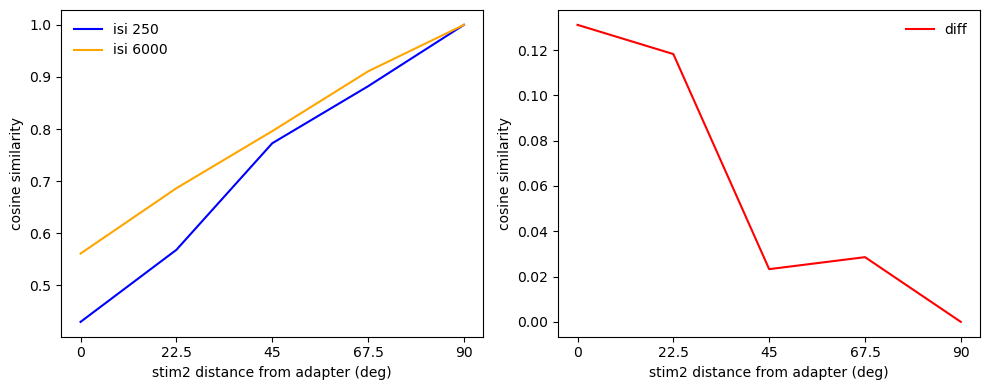

In [133]:
cos_sim_list = np.array(cos_sim_list)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
ax[0].plot(cos_sim_list[:nori], color='blue', label='isi 250')
ax[0].plot(cos_sim_list[nori:2*nori], color='orange', label='isi 6000')
ax[0].legend(frameon=False)

ax[1].plot(cos_sim_list[nori:2*nori] - cos_sim_list[:nori], color='red', label='diff')
ax[1].legend(frameon=False)

ax[0].set_xlabel('stim2 distance from adapter (deg)');
ax[0].set_ylabel('cosine similarity')
ax[0].set_xticks(range(nori), ['0', '22.5', '45', '67.5', '90'])

ax[1].set_xlabel('stim2 distance from adapter (deg)');
ax[1].set_ylabel('cosine similarity')
ax[1].set_xticks(range(nori), ['0', '22.5', '45', '67.5', '90'])

plt.tight_layout()
# fig_dir = r'C:\Users\lan\Documents\repos\inter\results\decorrelation vs adp\ref=90 deg'.replace('\\', os.sep)
# fig_name = 'decorr_vs_stim2_dist_' + current_area + '.pdf'
# # plt.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

## bootstrap subsample cell
bootstrap resample cells to get error bar

In [12]:
current_area = 'LI'
df_decorr = get_df_decorr(df_tidy, current_area=current_area)

nboot = 100
# subsample_cell_ratio = 0.7
# ncell_subsample = (df_tidy[(df_tidy.filter_cell_vis == True)]
#                    .groupby('area')
#                    .cell_id.nunique()
#                    .min()) # min ncells across areas - determine subsample size
cos_sim_boots = []

for iboot in tqdm(range(nboot)):
    
    np.random.seed(iboot)
    subsample_cell = np.random.choice(df_decorr.cell_id.unique(), 
                                    #   size=int(subsample_cell_ratio*df_decorr.cell_id.nunique()), 
                                    #   size=ncell_subsample,
                                      size=df_decorr.cell_id.nunique(), 
                                      replace=True)
    
    # df_pop_vec = df_decorr.sample(frac=1, 
    #                               replace=True, 
    #                               random_state=iboot) # resample cellxtrial (row-wise) with replacement, same size as original
    
    df_pop_vec = (df_decorr # [df_decorr.cell_id.isin(subsample_cell)]
                  .groupby(['isi', 'stim2_dist', 'cell_id'])
                  .dfof.median().reset_index() # cell-level median, under each isi-stim2_dist condition
                  .groupby(['isi', 'stim2_dist'])
                  .sample(frac=3, replace=True, random_state=iboot) # resample cells with replacement in each cond
                  .pivot_table(index=['isi', 'stim2_dist'], columns='cell_id', values='dfof') # df allows duplicate columns
                  .fillna(0) # fill nan with 0, bc some cells are not sampled in some conditions
                )
    nori = df_decorr.stim2_dist.nunique()
    nisi_now = df_decorr.isi.nunique() # discarded isi 750

    cos_sim_iboot = []
    for iisi in range(nisi_now):
        if iisi == 0:
            iref = 0
            # iref = 4
        elif iisi == 1:
            iref = nori
            # iref = nori+4 # -1 (0-based indexing) and +1 (go to next isi) cancel out
        pop_vec_ref = df_pop_vec.iloc[iref, :].values # reference pop vec: 0 deg target resp
        
        for iori in range(nori):
            irow = iisi * nori + iori
            pop_vec_ori = df_pop_vec.iloc[irow, :].values
            cos_sim = dot(pop_vec_ref, pop_vec_ori) / (norm(pop_vec_ref) * norm(pop_vec_ori))
            cos_sim_iboot.append(cos_sim)
            
    cos_sim_boots.append(cos_sim_iboot) # n of decorrelation pairs (nisi * nori)
    # cos_sim_boots.append(np.array(cos_sim_iboot[:5]) - np.array(cos_sim_iboot[5:])) # (nori), decorr diff within iboot (isi=250 - isi=6k)
    
len(cos_sim_boots), len(cos_sim_boots[0]) # n of boot, n of decorrelation pairs (nisi * nori)

100%|██████████| 100/100 [00:02<00:00, 39.28it/s]


(100, 10)

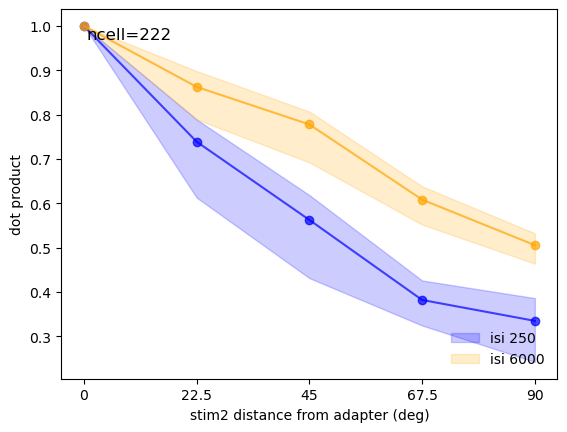

In [13]:
cos_sim_sets = np.array(cos_sim_boots)
cos_sim_sets_avg = np.mean(cos_sim_sets, axis=0) # across boots

perc = 2.5
plt.plot(cos_sim_sets_avg[:nori], color='blue', alpha=0.7, marker='o')
plt.fill_between(x=np.arange(nori),
                y1=np.percentile(cos_sim_sets, perc, axis=0)[:nori],
                y2=np.percentile(cos_sim_sets, 100-perc, axis=0)[:nori],
                label='isi 250',
                color='blue', alpha=0.2)

plt.plot(cos_sim_sets_avg[nori:], color='orange', alpha=0.7, marker='o')
plt.fill_between(x=np.arange(nori),
                y1=np.percentile(cos_sim_sets, perc, axis=0)[nori:],
                y2=np.percentile(cos_sim_sets, 100-perc, axis=0)[nori:],
                label='isi 6000',
                color='orange', alpha=0.2);

# annotate ncell at top left
plt.text(0.05, 0.95, f'ncell={df_decorr.cell_id.nunique()}', transform=plt.gca().transAxes, fontsize=12, va='top', ha='left')
plt.legend(frameon=False, loc='lower right')

# ## annotate significance
# for iori in np.arange(nori)[:-1]: # exclude 90 deg
#     plt.annotate(sig_star_list[iori], xy=(iori, 1), fontsize=12, ha='center', va='center')

# plt.ylim(0.2, 1.05)
plt.xlabel('stim2 distance from adapter (deg)');
# plt.ylabel('cosine similarity')
plt.ylabel('dot product')
plt.xticks(range(nori), ['0', '22.5', '45', '67.5', '90']);

# fig.tight_layout();
# fig_dir = r'C:\Users\lan\Documents\repos\inter\results\decorrelation vs adp\ref=90 deg'.replace('\\', os.sep)
# fig_name = f'decorr_fixed_resample_boot_CI{int(100-2*perc)}_median_bonf_vis_dot_prod_' + current_area + '.pdf'
# plt.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

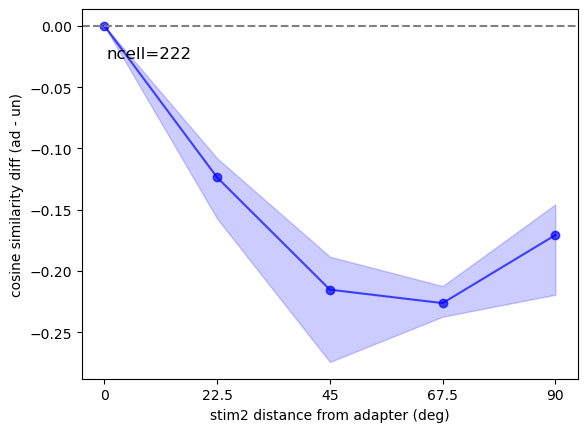

In [15]:
cos_sim_sets = np.array(cos_sim_boots)
cos_sim_sets_250 = cos_sim_sets[:, :nori]
cos_sim_sort_250 = np.sort(cos_sim_sets_250, axis=0) # sort each column
cos_sim_sets_6k = cos_sim_sets[:, nori:]
cos_sim_sort_6k = np.sort(cos_sim_sets_6k, axis=0)

cos_sim_sets = cos_sim_sort_250 - cos_sim_sort_6k
cos_sim_sets_avg = np.mean(cos_sim_sets, axis=0) # across boots

perc = 2.5
plt.plot(cos_sim_sets_avg[:nori], color='blue', alpha=0.7, marker='o')
plt.fill_between(x=np.arange(nori),
                y1=np.percentile(cos_sim_sets, perc, axis=0)[:nori],
                y2=np.percentile(cos_sim_sets, 100-perc, axis=0)[:nori],
                label='isi 250 - isi 6000',
                color='blue', alpha=0.2)

# annotate ncell at top left
plt.text(0.05, 0.9, f'ncell={df_decorr.cell_id.nunique()}', transform=plt.gca().transAxes, fontsize=12, va='top', ha='left')
plt.axhline(0, color='grey', linestyle='--')

# plt.ylim(0.2, 1.05)
plt.xlabel('stim2 distance from adapter (deg)');
plt.ylabel('cosine similarity diff (ad - un)')
plt.xticks(range(nori), ['0', '22.5', '45', '67.5', '90']);

# fig.tight_layout();
# fig_name = f'decorr_CI{int(100-2*perc)}_cos_simil_diff_' + current_area + '.pdf'
# plt.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')